<p style="font-size:34px;text-align:center"> <b> Personalized Cancer Diagnosis </b></p>

<h1>1. Business Problem </h1>

<h2>1.1. Description and Details </h2><br>

<p> <b>Source</b>: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p><br>
<p> <b>Data</b>: Memorial Sloan Kettering Cancer Center (MSKCC). Download the training text and training variant data from kaggle.</p><br>
<p> <b>My Understanding</b>:</p>
<p>  There are various types of genes and for each gene there are variations. So each individual, what gene and variation they have, the individual can be classified in nine categories. And some of these classes lead to some kind of cancer.</p>
<p>The workflow is as follows:</p>
<p>1. A molecular pathologist selects a list of genetic variations of interest that he/she want to analyze</p>
<p>2. The molecular pathologist searches for evidence in the medical literature that is relevant to the genetic variations of interest.</p>
<p>3. Finally this molecular pathologist spends huge amount of time analyzing the evidence related to each of the variations to classify them into one of the nine categories.</p>
<p></p>
<p><b>My Goal</b> is to replace the step 3 with a ML Model. The molecular pathologist will still have to decide which variations are of interest, and also collect the relevant evidence for them. but the last step, which is also the most time consuming will be fully automated.</p>
<br>
<p><b>Problem statement:</b></p>
<p> Classify the given variations/mutations based on evidence from text-based clinical literature</p>

<h2>1.2 Business Objectives and Constraints</h2> 

* Low Latency requirement is not there. (Time is not a constraint)
* Interpretation of our decision by doctors is important because it is a question of life and death
* Errors can be really costly so our focus should be on least errors
* Probabilty of a data point belonging to each class is needed

<h1>2. Machine Learning Problem Formulation</h1>
<h2>2.1 Data </h2>
<h3>2.1.1. Overview</h3>


- We have 2 files, one of them contains the information about the genetic mutations and the other about the clinical evidence (text) that pathologists use to classify the genetic mutations
- The files have a common field of ID

- <p> Data file information:
    <ul> 
        <li> 
            training_variants (ID, Gene, Variations, Class)
        </li>
        <li>
            training_text (ID, Text)
        </li>
    </ul>
</p>    
- Thus we perform the join operation on two data to get all the data at one place

<h3>2.1.2. Example Data Points</h3>

<h6> Training_Variants</h6>
<hr>
ID, Gene, Variation, Class<br>
6	CBL	V430M	5<br>
7	CBL	Deletion	1<br>
8	CBL	Y371H	4<br>
9	CBL	C384R	4<br>
.
<h6> Training_text </h6>
<hr>
ID, Text <br>
6	CBL	V430M	5
7	CBL	Deletion	1
8	CBL	Y371H	4
9	CBL	C384R	4

<h2>2.2. Mapping the real-world problem to an ML problem</h2><br>

<h3>2.2.1. Type of Machine Learning Problem</h3>
<p>
        There are nine different classes a genetic mutation (gene and variation) can be classified into => A Multi Class Classfication Problem
</p>    

<h3>2.2.2. Performance Metric</h3>


As mentioned on kaggle https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview/evaluation :<br>
 <b>Metric(s):</b>
* Multiclass Log-loss
* Confusion Matrix

And it is exactly what should be selected, reason being, in Log Loss we use the exact probability for a datapoint i to belong to each class. i.e what is the probability that it belongs to class 1,2,3,4..,9 and then we compute the loss. 

<h3>2.2.3. Machine Learning Objectives and Constraints</h3>

<p><b>Objective:</b> Predict the probability of each data-point belonging to each of the nine classes.<br><br>
    <b>Constraints:</b><br></p>   
    <ul>
    <li>Interpretability</li>
    <li>Class probabilities are needed</li>
    <li>Penalize the errors in class probabilities => Metric is Log-Loss</li>
    <li>No Latency Constraints</li>
    </ul>
 

<h2>2.3. Train, CV and Test Datasets</h2>

<p>We can observe that there is no temporal, time based feature present in our data. Thus, Split the dataset randomly into three parts train, cross validation and test with 64%, 16% and 20% of data respectively</p>

<h1>3. Exploratory Data Analysis</h1>

In [1]:
conda install mlxtend --channel conda-forge

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - mlxtend


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mlxtend-0.19.0             |     pyhd8ed1ab_0         1.2 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.2 MB

The following NEW packages will be INSTALLED:

  mlxtend            conda-forge/noarch::mlxtend-0.19.0-pyhd8ed1ab_0



mlxtend-0.19.0       | 1.2 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda update -n base -c defaults conda

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py38hecd8cb5_0         2.9 MB
    xmltodict-0.12.0           |     pyhd3eb1b0_0          13 KB
    ------------------------------------------------------------
                                           Total:         2.9 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.10.3-py38h50d173~ --> pkgs/main::conda-4.10.3-py38hecd8cb5_0

The following packages will be DOWNGRADED:

  xmltodict                                     0.12.0-py_0 --> 0.12.0-pyhd3eb1b0_0



conda-4.10.3         | 2.9 MB    | ##################################### | 100% 
xmltodict-0.12.0     | 13 KB     | ##################################### | 100% 

In [3]:
conda install -c conda-forge imbalanced-learn

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    imbalanced-learn-0.8.0     |     pyhd8ed1ab_0         109 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         109 KB

The following NEW packages will be INSTALLED:

  imbalanced-learn   conda-forge/noarch::imbalanced-learn-0.8.0-pyhd8ed1ab_0

The following packages will be SUPERSEDED by a higher-priority channel:

  conda              pkgs/main::conda-4.10.3-py38hecd8cb5_0 --> conda-forge::conda-4.10.3-py38h50d1736_0



imbalanced-learn-0.8 | 109 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kern

In [6]:
pip install scikit_learn

Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as p
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as n
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
#from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

<h2>3.1 Reading Data </h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

<p> 
    Training/Training_variants is a comma separated file containing the description of the genetic mutations used for training.<br>
    Fields are:
    <ul>
        <li><b>ID : </b>The id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b> The gene where the genetic mutation is located</li>
        <li><b>Variation : </b>The aminoacid change for this mutations</li>
        <li><b>Class : </b>1-9th class this genetic mutation has been classified on</li>
    </ul>
        

In [29]:
data=p.read_csv("training_variants")
print("Training Variants Shape:",data.shape)
print("Feature names:",data.columns.values)
data.head(10)

Training Variants Shape: (3321, 4)
Feature names: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [30]:
null_cols=data.columns[data.isnull().any()]
print(data[null_cols].isnull().sum())

Series([], dtype: float64)


<h3>3.1.2. Reading Text Data</h3>

<p>Here the separator is || not comma so we need to specify it while reading the data </p>

In [31]:
#Here we need to provide name of columns explicitly because ID,Text are comma separated. And we skip first row
data_text=p.read_csv("training_text",sep="\|\|",names=['ID','Text'],skiprows=1)
print("Training Text data shape:",data_text.shape)
data_text.head()

Training Text data shape: (3321, 2)


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>3.1.3. Preprocessing of Text Begins</h3>

In [32]:
str1="Here is a string %6 534 @"
str1=re.sub('[^A-Za-z0-9]+', ' ', str1)

In [33]:
re.sub('\s+',' ',str1)

'Here is a string 6 534 '

In [34]:
for index,row in data_text.iterrows():
    print(type(row['Text']))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [35]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sudhanshurai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
stop_words=set(stopwords.words('english'))
print(stop_words)

def text_cleaning(text, index):
    if type(text) is not int:
        string=""
        text=re.sub('[^A-Za-z0-9]+', ' ', text)
        text=re.sub('\s+',' ',text)
        text=text.lower()
        
        for word in text.split():
            if not word in stop_words:
                string+=word+" "
        data_text['Text'][index]=string        

{"she's", "you're", "it's", 'their', 'so', 'theirs', 'all', "you've", 'during', 'once', 'because', 'your', 'on', 'should', 'to', 'ours', 'into', 'by', 'shan', 'hadn', 'she', 'whom', 'this', 'off', 'ourselves', 'are', 'been', 're', 'her', 'any', 'then', 'do', 'themselves', 'mustn', "that'll", 'yourselves', 'down', "doesn't", 'but', "wasn't", 'now', 'shouldn', 'be', 'can', 'our', 'under', 'above', 'don', 'a', 'its', 'yours', 'after', 'and', 'y', "needn't", "didn't", 'for', 'doesn', 'other', 'which', 'weren', 'over', 'nor', "mightn't", 'where', 'o', 'own', 'up', 'how', 'didn', 'such', 'wouldn', 'is', 'had', 'there', 'needn', 'doing', "weren't", 'd', 'no', 'haven', 'very', 'between', 'wasn', 'won', 'why', 'those', 'does', 'his', 'most', 'ain', "aren't", 'just', 'both', "shan't", "wouldn't", "mustn't", 's', 'i', 'itself', 'herself', 'being', 'from', 'with', 'hers', 'ma', 'himself', 'when', 'has', "you'll", "you'd", 'it', 'they', 'who', 'will', "shouldn't", 'until', 'below', 'out', 'again', 

In [37]:
for index,row in data_text.iterrows():
    if type(row['Text']) is str:
        text_cleaning(row['Text'],index)
    else:
        print("No text found in text column of row:",index)

No text found in text column of row: 1109
No text found in text column of row: 1277
No text found in text column of row: 1407
No text found in text column of row: 1639
No text found in text column of row: 2755


In [38]:
print(data_text['Text'][0])

cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increases ets2 v ets erythroblastosis virus e26 oncogene homolog 2 driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk10 modulates ets2 activity generally functions cdk10 remain elusive demonstrate cdk10 cyclin dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam58a whose mutations cause star syndrome human developmental anomaly whose features include toe syndactyly telecanthus anogenital renal malformations show star syndrome associated cyclin mutants unable interact cdk10 cyclin silencing phenocopies cdk10 silencing increasing c raf conferring tamoxifen resistance breast cancer cells cdk10 cyclin phosphorylates ets2 vitro cells positively controls ets2 degradation proteasome ets2 protein levels increas

In [39]:
#now we will combine our two different datasets and save the cleaned data into new csv file
processed_data=p.merge(data,data_text, on='ID',how='left')
processed_data.head()
processed_data.to_csv('processed_data.csv')

In [40]:
#now we are reading our processed data as data

In [41]:
data=p.read_csv('processed_data.csv')

In [42]:
data.head()

,Unnamed: 0,ID,Gene,Variation,Class,Text
0,0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [43]:
#we observed that there are a few rows in which text data is blank. so we just enter the gene name and variation in these fields
data[data.isnull().any(axis=1)]

,Unnamed: 0,ID,Gene,Variation,Class,Text
1109,1109,1109,FANCA,S1088F,1,NaN
1277,1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,1407,FGFR3,K508M,6,NaN
1639,1639,1639,FLT1,Amplification,6,NaN
2755,2755,2755,BRAF,G596C,7,NaN


In [44]:
data.loc[data['Text'].isnull(),'Text']=data['Gene']+' '+data['Variation']
data[data['ID']==2755]

,Unnamed: 0,ID,Gene,Variation,Class,Text
2755,2755,2755,BRAF,G596C,7,BRAF G596C


<h3>3.1.4. Train, Test and Cross Validation Split</h3>
<p> We will break our data first in 80-20 ratio into Train and Test and then 80% of Train data will be further broken into 80:20 ratio for Train and Cross Validation data. Thus making the Train:Test:CV ratio as 64:20:16.</p><p> This is just random break, you can choose whatever ratio you like.</p>
<br>
<p>Before breaking our data, we need to make sure that if the data is imbalanced, then the test, train and CV data should have the same proportion of different class labels as the original data. For this we have <b>stratify</b> variable in train_test_split method, where we pass the class label values and our data is broken in exact proportionality.</p>

In [45]:
class_data=data['Class'].values

X_train, X_test, y_train, y_test=train_test_split(data,class_data,stratify=class_data,test_size=0.2)
X_train, X_cv, y_train, y_cv=train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

print("Total points in X_train is:",X_train.shape[0])
print("Total points in X_test is:",X_test.shape[0])
print("Total points in X_cv is:",X_cv.shape[0])

Total points in X_train is: 2124
Total points in X_test is: 665
Total points in X_cv is: 532


<h6>3.1.4.2 Validation of Proportionality in which Data is broken</h6>
<p> Here we plot the bar graph for each distribution and check if each class label is equally distributed in each category.</p>


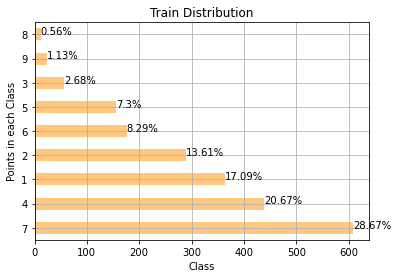

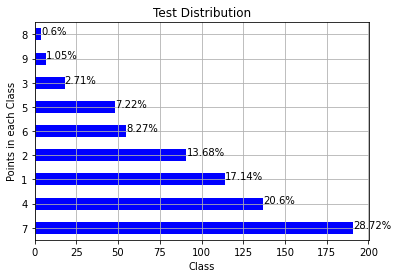

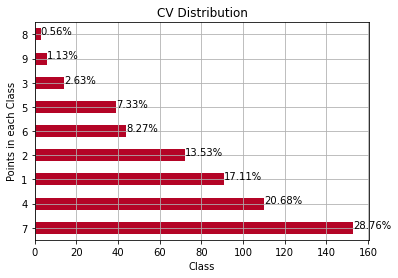

In [46]:
train_dist=X_train['Class'].value_counts()
test_dist=X_test['Class'].value_counts()
cv_dist=X_cv['Class'].value_counts()

train_dist.plot(kind='barh',colormap='copper_r')
plt.xlabel('Class')
plt.ylabel('Points in each Class')
plt.title('Train Distribution')
plt.grid()
for index,value in enumerate(train_dist):
    s=n.round(value/X_train.shape[0]*100,2)
    s1=str(s)+"%"
    plt.text(value, index, s1)
plt.show()


test_dist.plot(kind='barh',colormap='winter')
plt.xlabel('Class')
plt.ylabel('Points in each Class')
plt.title('Test Distribution')
plt.grid()
for index,value in enumerate(test_dist):
    s=n.round(value/X_test.shape[0]*100,2)
    s1=str(s)+"%"
    plt.text(value, index, s1)
plt.show()


cv_dist.plot(kind='barh',colormap='coolwarm_r')
plt.xlabel('Class')
plt.ylabel('Points in each Class')
plt.title('CV Distribution')
plt.grid()
for index,value in enumerate(cv_dist):
    s=n.round(value/X_cv.shape[0]*100,2)
    s1=str(s)+"%"
    plt.text(value, index, s1)
plt.show()



<p><b>NOTE:</b> It can be observed that all the three distributions are almost equal by the proportion of the class labels. For example we can see that for class label 1, train, test and CV distributions have 17.09%, 17.14% and 17.11% of class label 1 respectively. </p>

In [47]:
import numpy as n
t=n.random.rand(1,9)
z=((t/sum(sum(t))))
print(z[0])
print(z)

[0.04989861 0.03432663 0.2210407  0.12642751 0.20930786 0.13090255
 0.06002899 0.11162485 0.0564423 ]
[[0.04989861 0.03432663 0.2210407  0.12642751 0.20930786 0.13090255
  0.06002899 0.11162485 0.0564423 ]]


<h2>3.2 Random Model</h2>

In [48]:
z=n.zeros((X_cv.shape[0],9)).shape
print(X_cv.shape[0])
print(z)

532
(532, 9)


<p>In case of log loss, the range of possible values is [0,infinity) where 0 depicts the ideal model and a very high value depicts a random model. To find the upper limit, we generate random values as predicted values and compute its log loss so that we can have the upper limit of log loss. </p><p>We will compute nine random class probabilites for each class such that their sum is equal to one.</p>

In [49]:
#we find number of rows in cv and test data
len_X_cv=X_cv.shape[0]
len_X_test=X_test.shape[0]

#we create a output array that has exactly same size as the CV data
#Log_Loss: In Log loss we compute the (-1/n)summation summation(yij*log(pij)). since we have multiclass classification,
#yij is equal to 1 for correct class label, and for others its equal to 0. and we multiply it with predicted probability of
#that class label. so if the prob is high, log value will be less. If the prob for correct class label is low, then the log 
#value will be high. That is why we need log loss as less as possible. 


predicted_y_cv=n.zeros((len_X_cv,9))
predicted_y_test=n.zeros((len_X_test,9))


for i in range(len_X_cv):
    random_prob=n.random.rand(1,9)
    predicted_y_cv[i]=random_prob/sum(sum(random_prob))
print("Log Loss from Random generated model for CV data is :",log_loss(y_cv,predicted_y_cv))


for i in range(len_X_test):
    random_probs=n.random.rand(1,9)
    predicted_y_test[i]=random_probs/sum(sum(random_probs))
print("Log Loss from Random generated model for Test data is :",log_loss(y_test,predicted_y_test))


Log Loss from Random generated model for CV data is : 2.4840711749821893
Log Loss from Random generated model for Test data is : 2.4238561393093456


In [50]:
#Confusion matrix where x axis is Predicted Class, and y axis is Original Class
confusion_matrix(y_test, n.argmax(predicted_y_test,axis=1)+1) 

array([[ 9,  8, 12, 16, 11,  6, 17, 20, 15],
       [14,  5, 17,  9, 11,  9, 12,  6,  8],
       [ 2,  2,  1,  2,  1,  1,  2,  5,  2],
       [12, 14, 14, 17, 18, 22, 12, 13, 15],
       [ 1,  5,  6,  4,  4,  7,  5,  5, 11],
       [ 4, 12,  7,  3,  8,  5,  4,  6,  6],
       [22, 14, 20, 25, 20, 19, 21, 23, 27],
       [ 0,  1,  0,  0,  1,  2,  0,  0,  0],
       [ 0,  1,  2,  0,  0,  1,  0,  2,  1]])

<h2> 3.3 Univariate Analysis </h2>

<p>In univariate analysis, we analysis individual features, their distributions, PDF, CDF, and try to find how much does a specific feature impacts the y class label. Since in this case we have 2 categorical features and one text feature so we will learn how to handle categorical data first. We will do one hot encoding and response coding to convert categorical features into vectors so that we can apply Machine Learning models to check how much impact does a specific feature has on y label. </p>

<p> <b>ONE HOT ENCODING:</b> In one hot encoding, if there are n distinct values in feature (categorical), we create a (1*n) dim array. Each value corresponding to a value in feature. And where all values are zero except the value in a specific row. e.g. feature {"Red","Green","Yellow"}, will have array as [0,0,0]. For rows with Red [1,0,0], Green [0,1,0] and Yellow [0,0,1].The issue with this is, that when the distinct values are high, eg country or pincode, we need to create very large dim metrices which are sparse. One Hot Encoding works well with Logistic Regression.  </p>

<p><b>RESPONSE CODING:</b> This is another method to handle categorical data. Here every gene (one of categorical feature) is replaced with a vector of 9 dim (total class labels), and each cell contains P(y=j | gene), i.e probability of class label as j (1-9) given gene i. When we elaborate on this, for a gene 'BRCAI', suppose it occurs 100 times. Out of this 1 occurs 20 times, 2 occures 30 times and 7 occures 50 times. So our vector becomes, [0.2,0,3,0,0,0,0,0.5,0,0]. So for these 100 times, we replace it by this vector. And so on for every gene. It is effective in handling large value of categorical features and Response Coding is effective in Random Forest Algorithm.  </p><p>We have created two methods below for generating response coded features. 'get_unique_feature_dictionary' function returns a dictionary with unique category values as key, and for value it has a list of size 9, which contains the probabilities as explained above. "get_response_coded_features" function calls the above function to get the list of prob and then for every value corresponding to original feature, it creates a new value containing a list of 9 probabilities. This is response coding.  </p>

<h3> Gene Feature </h3>

In [51]:
#print(X_cv['Gene'].value_counts())
#BRCA1     48
#TP53      28
#PTEN      25
#EGFR      21
#BRCA2     19
#          ..
#RASA1      1

#print(X_train.loc[(X_train['Class']==1) & (X_train['Gene']=='BRCA1'))
#Unnamed: 0    ID   Gene             Variation  Class  \
#2455        2455  2455  BRCA1                H1746N      1   
#2579        2579  2579  BRCA1                G1763V      1   
#2483        2483  2483  BRCA1                H1686R      1   
#2501        2501  2501  BRCA1                K1702E      1   
#2634        2634  2634  BRCA1                W1718L      1   
#2569        2569  2569  BRCA1                Q1811R      1   

#print(X_train.loc[(X_train['Class']==1) & (X_train['Gene']=='BRCA1')].shape[0])
#40
#(it shows that there are 40 values with Gene='BRCA1' and Class=1)


#print(X_train.loc[(X_train['Class']==5) & (X_train['Gene']=='BRCA1')].shape[0])
#54
#(it shows that there are 54 values with Gene='BRCA1' and Class=5)

In [52]:
#this method will return a dictionary containing unique categorical features as key and a list [] containing 9 probabilties
# for each key as value.
# First we grouped categories with their frequencies in variable 'value_count'. Then for every category we compute 9 probabilites
# out of frequency of that category.

def get_unique_feature_dictionary(alpha, feature, df): #alpha is for Laplace smoothing
    value_count= X_train[feature].value_counts()
    feature_dict=dict()
    
    for i,denominator in value_count.items():
        vec=[]
        for k in range(1,10):
            feature_cnt=X_train.loc[(X_train[feature]==i)&(X_train['Class']==k)].shape[0]
            vec.append((feature_cnt+alpha*10)/(denominator+alpha*90)) #Laplace smoothing
        feature_dict[i]=vec
    return feature_dict

print(get_unique_feature_dictionary(1,'Gene',X_train))
#{'BRCA1': [0.1968503937007874, 0.03937007874015748, 0.07874015748031496, 0.14173228346456693, 0.25196850393700787, 0.1732283464566929, 0.03937007874015748, 0.03937007874015748, 0.03937007874015748], 'TP53': [0.31155778894472363, 0.06030150753768844, 0.05527638190954774, 0.2914572864321608, 0.06030150753768844, 0.06532663316582915, 0.05025125628140704, 0.05025125628140704, 0.05527638190954774],...
#It can happen that the numerator has value 1 and denominator has 100, so it will lead to very small values. Thus we do Laplace
#smoothing. (numerator+alpha*10)/(denominator+alpha*90)



{'BRCA1': [0.183206106870229, 0.03816793893129771, 0.08015267175572519, 0.15267175572519084, 0.26717557251908397, 0.16412213740458015, 0.03816793893129771, 0.03816793893129771, 0.03816793893129771], 'TP53': [0.3350253807106599, 0.06598984771573604, 0.05583756345177665, 0.26903553299492383, 0.05583756345177665, 0.06091370558375635, 0.050761421319796954, 0.050761421319796954, 0.05583756345177665], 'EGFR': [0.060109289617486336, 0.18579234972677597, 0.060109289617486336, 0.07103825136612021, 0.07103825136612021, 0.060109289617486336, 0.3825136612021858, 0.0546448087431694, 0.0546448087431694], 'BRCA2': [0.12280701754385964, 0.05847953216374269, 0.05847953216374269, 0.07602339181286549, 0.15204678362573099, 0.3567251461988304, 0.05847953216374269, 0.05847953216374269, 0.05847953216374269], 'PTEN': [0.07878787878787878, 0.06060606060606061, 0.07878787878787878, 0.4666666666666667, 0.06666666666666667, 0.06060606060606061, 0.06666666666666667, 0.06060606060606061, 0.06060606060606061], 'BRAF

In [53]:
#print(X_cv['Gene'].value_counts())
#BRCA1     48
#TP53      28
#PTEN      25
#EGFR      21
#BRCA2     19
#          ..
#RASA1      1

#print(X_train.loc[(X_train['Class']==1) & (X_train['Gene']=='BRCA1'))
#Unnamed: 0    ID   Gene             Variation  Class  \
#2455        2455  2455  BRCA1                H1746N      1   
#2579        2579  2579  BRCA1                G1763V      1   
#2483        2483  2483  BRCA1                H1686R      1   
#2501        2501  2501  BRCA1                K1702E      1   
#2634        2634  2634  BRCA1                W1718L      1   
#2569        2569  2569  BRCA1                Q1811R      1   

#print(X_train.loc[(X_train['Class']==1) & (X_train['Gene']=='BRCA1')].shape[0])
#40
#(it shows that there are 40 values with Gene='BRCA1' and Class=1)


#print(X_train.loc[(X_train['Class']==5) & (X_train['Gene']=='BRCA1')].shape[0])
#54
#(it shows that there are 54 values with Gene='BRCA1' and Class=5)

In [54]:
#This method will use the above method and generate a feature corresponding to our categorical feature, where every value will 
#be replaced by 9 dim vector for that feature as shown above.

def get_response_coded_features(alpha, feature, df):
    fea_dict=get_unique_feature_dictionary(alpha, feature, df)
    value_count_train=X_train[feature].value_counts()
    
    new_features=[]
    for index,row in df.iterrows():
        if row[feature] in dict(value_count_train).keys():
            new_features.append(fea_dict[row[feature]])
        else:
            new_features.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
        
    return new_features

#print(n.array(get_response_coded_features(1,"Gene",X_train)))
#[[0.14285714 0.08928571 0.08928571 ... 0.08928571 0.08928571 0.08928571]
# [0.12371134 0.11340206 0.10309278 ... 0.12371134 0.10309278 0.10309278]
# [0.31472081 0.06091371 0.05583756 ... 0.05076142 0.05076142 0.05583756]
# ...
# [0.0877193  0.09649123 0.0877193  ... 0.21929825 0.0877193  0.0877193 ]
# [0.08396947 0.08396947 0.12977099 ... 0.29007634 0.07633588 0.07633588]
# [0.1122449  0.10204082 0.1122449  ... 0.10204082 0.10204082 0.10204082]]

#print(n.array(get_response_coded_features(1,"Gene",X_train)).shape)
#(2124, 9)

<li>Now we will start Univariate analysis of Gene feature. We will see its distribution pattern.</li>

In [55]:
unique_genes=X_train['Gene'].value_counts()
print("Unique Genes or total categories in X_train:",unique_genes.shape[0])
print(unique_genes.head(10))

Unique Genes or total categories in X_train: 227
BRCA1     172
TP53      107
EGFR       93
BRCA2      81
PTEN       75
BRAF       64
KIT        64
ERBB2      48
ALK        41
PDGFRA     39
Name: Gene, dtype: int64


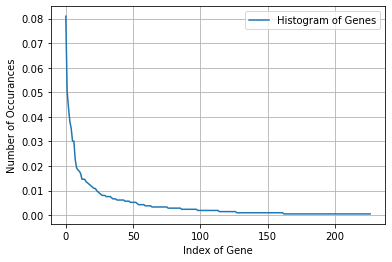

In [56]:
#PDF
s=sum(unique_genes.values)
h=unique_genes.values/s
plt.plot(h,label="Histogram of Genes")

plt.xlabel("Index of Gene")
plt.ylabel("Number of Occurances")
plt.legend()
plt.grid()
plt.show()

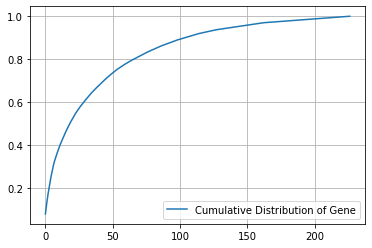

In [57]:
#CDF
cd=n.cumsum(h)
plt.plot(cd,label="Cumulative Distribution of Gene")
plt.grid()
plt.legend()
plt.show()

#We note that the distribution of different genes is skewed in X_train. Top 50 genes cover 75% of data.

<li>Now we will convert our Gene feature into vector form by using both methods.</li>
<h4>1. Response Coding</h4>

In [58]:
alpha=1 #Laplace smoothing parameter
ResponseCoded_Gene_Train=n.array(get_response_coded_features(alpha,"Gene",X_train))
ResponseCoded_Gene_Test=n.array(get_response_coded_features(alpha,"Gene",X_test))
ResponseCoded_Gene_CV=n.array(get_response_coded_features(alpha,"Gene",X_cv))
print(ResponseCoded_Gene_Train.shape)
print(ResponseCoded_Gene_Test.shape)
print(ResponseCoded_Gene_CV.shape)

(2124, 9)
(665, 9)
(532, 9)


<h4>2. One Hot Encoding</h4>

In [77]:
one_hot_encoding= CountVectorizer()
OneHotEncoded_Gene_Train=one_hot_encoding.fit_transform(X_train['Gene'])
OneHotEncoded_Gene_Test=one_hot_encoding.transform(X_test['Gene'])
OneHotEncoded_Gene_cv=one_hot_encoding.transform(X_cv['Gene'])
print(OneHotEncoded_Gene_cv.shape)
print(OneHotEncoded_Gene_Train.shape)
print(OneHotEncoded_Gene_Test.shape)

#Note: We used fit_transform for train and transform for test and cv, reason being when we fit_transform on train, we get 233
#columns. If we do fit_transform on test and cv too, we will get different number of columns in each which will lead to sample
#fields mismatch while predicting probabilities. Thus we use transform to make sure that test and cv has same size as train.
#if used fit_transform
#(532, 142)
#(2124, 233)
#(665, 152)
#error: X has 142 features per sample; expecting 233

(532, 226)
(2124, 226)
(665, 226)


<h3>3.3.1 Predicting y using Feature "Gene"</h3>

<p>Now that we have converted our categorical feature into vector format using two different techniques, now we will use this new feature in a model with class y, to see how much helpful is this feature/ contribution of this feature in predicting yi s. For this we use general purpose classfier called <b>SGDClassifier()</b>. SGD stands for Stochastic Gradient Descent, where the value we pass in loss variable decides which algorithm is applied. loss='hinge' applies linear SVM. Loss='log' applies Logistic Regression. </p>
<p><b>Calibrated Classifier:</b> We do calibration because certain model only predict y as 0 or 1. So in calibration we predict the probabilities of y as 0 and 1. These probabilities are important in computing Log Loss. So we need to predict the probabilites. (See yellow notebook, Miscellaneous Topics). In Calibration model we use sigmoidal method ( sin wave function) or isotonic regression of staircase method. Read notebook for more details.</p>

In [78]:
alpha=[10 ** x for x in range(-6,2)]

log_loss_array_OHE=[] 
for i in alpha:
    
    clf=SGDClassifier(alpha=i,loss='log',random_state=50)
    clf.fit(OneHotEncoded_Gene_Train, y_train)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(OneHotEncoded_Gene_Train,y_train)
    
    predict_y_cv=cali_clf.predict_proba(OneHotEncoded_Gene_cv)
    #print(predict_y_cv)
    log_loss_array_OHE.append(log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))
    print("Alpha=",i," Log Loss=",log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))

Alpha= 1e-06  Log Loss= 1.289704336325801
Alpha= 1e-05  Log Loss= 1.206967770557759
Alpha= 0.0001  Log Loss= 1.171759782549353
Alpha= 0.001  Log Loss= 1.2055064470162722
Alpha= 0.01  Log Loss= 1.3210975754112524
Alpha= 0.1  Log Loss= 1.4282460068905154
Alpha= 1  Log Loss= 1.469294668810872
Alpha= 10  Log Loss= 1.4745708608353685


In [79]:
log_loss_array_RC=[] 
for i in alpha:
    
    clf=SGDClassifier(alpha=i,loss='log',random_state=50)
    clf.fit(ResponseCoded_Gene_Train, y_train)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(ResponseCoded_Gene_Train,y_train)
    
    predict_y_cv=cali_clf.predict_proba(ResponseCoded_Gene_CV)
    #print(predict_y_cv)
    log_loss_array_RC.append(log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))
    print("Alpha=",i," Log Loss=",log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))

Alpha= 1e-06  Log Loss= 1.2338024703836932
Alpha= 1e-05  Log Loss= 1.2354086564894962
Alpha= 0.0001  Log Loss= 1.2524190730869196
Alpha= 0.001  Log Loss= 1.311020106626763
Alpha= 0.01  Log Loss= 1.3458102564520957
Alpha= 0.1  Log Loss= 1.354725310287438
Alpha= 1  Log Loss= 1.3635092467135403
Alpha= 10  Log Loss= 1.342923208681017


In [80]:
best_alpha=alpha[n.argmin(log_loss_array_OHE)]
clf=SGDClassifier(alpha=best_alpha,loss='log',penalty='l2',random_state=50)
clf.fit(OneHotEncoded_Gene_Train,y_train)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(OneHotEncoded_Gene_Train,y_train)

predict_y_cv=cali_clf.predict_proba(OneHotEncoded_Gene_Train)
print("Cross Validation Log Loss:",log_loss(y_train,predict_y_cv,labels=clf.classes_,eps=1e-15))

predict_y_test=cali_clf.predict_proba(OneHotEncoded_Gene_Test)
print("Test Data Log Loss:",log_loss(y_test,predict_y_test,labels=clf.classes_,eps=1e-15))

Cross Validation Log Loss: 0.9947936904971039
Test Data Log Loss: 1.1827688488198707


In [81]:
#ref:
#import pandas as pd   
# making data frame from csv file 
#data = pd.read_csv("employees.csv") 
# creating a bool series from isin() 
#new = data["Gender"].isin(["Male"]) 
# displaying data with gender = male only 
# data[new] 

<p><b>NOTE:</b> We also need to check stability of given feature across train, test and CV. When we say stability, it is possible that train contains A,B,C as categorical values, and CV and Test has, D,E,F and G,H,I as categorical values. In that case our feature is not reliable as we dont know how many of the total category values are covered in test and CV.</p>

In [82]:
test_cov=X_test[X_test["Gene"].isin(list(set(X_train["Gene"])))].shape[0]
cv_cov=X_cv[X_cv["Gene"].isin(list(set(X_train["Gene"])))].shape[0]

print("Out of ",X_test.shape[0]," points in test data ",test_cov," are present in train.")
print("Out of ",X_cv.shape[0], " points in cv data ",cv_cov," are present in train.")

Out of  665  points in test data  641  are present in train.
Out of  532  points in cv data  512  are present in train.


<li><b>CONCLUSION:</b> We can conclude that "Gene" feature is stable across all the data sets.</li>

<h3> Variation Feature </h3>

In [83]:
unique_genes=X_train['Variation'].value_counts()
print("Unique Variations or total categories in X_train:",unique_genes.shape[0])
print(unique_genes.head(10))

Unique Variations or total categories in X_train: 1927
Truncating Mutations    57
Deletion                48
Amplification           45
Fusions                 23
Overexpression           4
Q61L                     3
EWSR1-ETV1 Fusion        2
Y42C                     2
S222D                    2
Q61H                     2
Name: Variation, dtype: int64


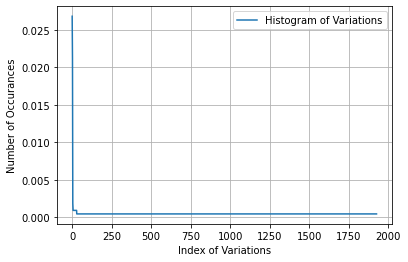

In [84]:
#PDF
s=sum(unique_genes.values)
h=unique_genes.values/s
plt.plot(h,label="Histogram of Variations")

plt.xlabel("Index of Variations")
plt.ylabel("Number of Occurances")
plt.legend()
plt.grid()
plt.show()

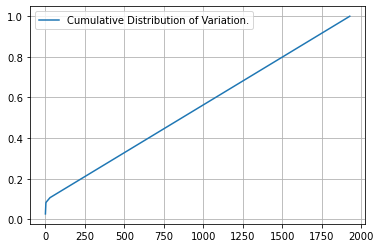

In [85]:
#CDF
cd=n.cumsum(h)
plt.plot(cd,label="Cumulative Distribution of Variation.")
plt.grid()
plt.legend()
plt.show()

#We note that baring the first few variations, most of the variations occures only once or twice.

<h4>1. Response Coding</h4>

In [86]:
alpha=1 #Laplace smoothing parameter
ResponseCoded_Var_Train=n.array(get_response_coded_features(alpha,"Variation",X_train))
ResponseCoded_Var_Test=n.array(get_response_coded_features(alpha,"Variation",X_test))
ResponseCoded_Var_CV=n.array(get_response_coded_features(alpha,"Variation",X_cv))
print(ResponseCoded_Var_Train.shape)
print(ResponseCoded_Var_Test.shape)
print(ResponseCoded_Var_CV.shape)

(2124, 9)
(665, 9)
(532, 9)


<h4>2. One Hot Encoding</h4>

In [87]:
one_hot_encoding= CountVectorizer()
OneHotEncoded_Var_Train=one_hot_encoding.fit_transform(X_train['Variation'])
OneHotEncoded_Var_Test=one_hot_encoding.transform(X_test['Variation'])
OneHotEncoded_Var_cv=one_hot_encoding.transform(X_cv['Variation'])
print(OneHotEncoded_Var_cv.shape)
print(OneHotEncoded_Var_Train.shape)
print(OneHotEncoded_Var_Test.shape)

(532, 1960)
(2124, 1960)
(665, 1960)


In [88]:
alpha=[10 ** x for x in range(-6,2)]

log_loss_array_OHE=[] 
for i in alpha:
    
    clf=SGDClassifier(alpha=i,loss='log',random_state=50)
    clf.fit(OneHotEncoded_Var_Train, y_train)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(OneHotEncoded_Var_Train,y_train)
    
    predict_y_cv=cali_clf.predict_proba(OneHotEncoded_Var_cv)
    #print(predict_y_cv)
    log_loss_array_OHE.append(log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))
    print("Alpha=",i," Log Loss=",log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))

Alpha= 1e-06  Log Loss= 1.7464779081008646
Alpha= 1e-05  Log Loss= 1.7087487634689418
Alpha= 0.0001  Log Loss= 1.7025103740708687
Alpha= 0.001  Log Loss= 1.7069459740003285
Alpha= 0.01  Log Loss= 1.7158081910300158
Alpha= 0.1  Log Loss= 1.7232655809860884
Alpha= 1  Log Loss= 1.7269379242078542
Alpha= 10  Log Loss= 1.7273894453989767


In [89]:
log_loss_array_RC=[] 
for i in alpha:
    
    clf=SGDClassifier(alpha=i,loss='log',random_state=50)
    clf.fit(ResponseCoded_Var_Train, y_train)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(ResponseCoded_Var_Train,y_train)
    
    predict_y_cv=cali_clf.predict_proba(ResponseCoded_Var_CV)
    #print(predict_y_cv)
    log_loss_array_RC.append(log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))
    print("Alpha=",i," Log Loss=",log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))

Alpha= 1e-06  Log Loss= 2.119259325014166
Alpha= 1e-05  Log Loss= 2.15930410366773
Alpha= 0.0001  Log Loss= 1.8690788804656633
Alpha= 0.001  Log Loss= 1.8311564130657454
Alpha= 0.01  Log Loss= 1.8189068597725244
Alpha= 0.1  Log Loss= 1.8199995573283112
Alpha= 1  Log Loss= 1.764579618617659
Alpha= 10  Log Loss= 1.7524135135864636


In [90]:
best_alpha=alpha[n.argmin(log_loss_array_OHE)]
clf=SGDClassifier(alpha=best_alpha,loss='log',penalty='l2',random_state=50)
clf.fit(OneHotEncoded_Var_Train,y_train)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(OneHotEncoded_Var_Train,y_train)

predict_y_cv=cali_clf.predict_proba(OneHotEncoded_Var_Train)
print("Cross Validation Log Loss:",log_loss(y_train,predict_y_cv,labels=clf.classes_,eps=1e-15))

predict_y_test=cali_clf.predict_proba(OneHotEncoded_Var_Test)
print("Test Data Log Loss:",log_loss(y_test,predict_y_test,labels=clf.classes_,eps=1e-15))

Cross Validation Log Loss: 0.7536543964937469
Test Data Log Loss: 1.6684627833128287


In [91]:
test_cov=X_test[X_test["Variation"].isin(list(set(X_train["Variation"])))].shape[0]
cv_cov=X_cv[X_cv["Variation"].isin(list(set(X_train["Variation"])))].shape[0]

print("Out of ",X_test.shape[0]," points in test data ",test_cov," are present in train.")
print("Out of ",X_cv.shape[0], " points in cv data ",cv_cov," are present in train.")

Out of  665  points in test data  73  are present in train.
Out of  532  points in cv data  50  are present in train.


<h3> Text Feature</h3>

In [92]:
print(X_train['Text'])

2003    mapk erk pathway ras raf mek erk pathway one e...
1815    abstract burkitt lymphoma bl frequent b cell l...
24      recent evidence demonstrated acquired uniparen...
1419    two mutations fgfr3 g380r g375c known cause ac...
382     tumor suppressor p53 393 amino acid transcript...
                              ...                        
2255    pten phosphatase tensin homolog phosphatase un...
1433    largest e3 ligase subfamily cul3 binds btb dom...
1638    abstract approach identify human oncogenes gen...
84      abstract rasopathies autosomal dominant disord...
2135    oxidative electrophilic stresses sensed keap1 ...
Name: Text, Length: 2124, dtype: object


<li>We will use One Hot Encoding Coding to featurize 'Text' feature.</li>

In [93]:
text_vectorizer=CountVectorizer(min_df=3)
OneHotEncoded_Text_Train=text_vectorizer.fit_transform(X_train['Text'])
OneHotEncoded_Text_Train=normalize(OneHotEncoded_Text_Train,axis=0)

OneHotEncoded_Text_Test=text_vectorizer.transform(X_test['Text'])
OneHotEncoded_Text_Test=normalize(OneHotEncoded_Text_Test,axis=0)

OneHotEncoded_Text_CV=text_vectorizer.transform(X_cv['Text'])
OneHotEncoded_Text_CV=normalize(OneHotEncoded_Text_CV,axis=0)

In [94]:
alpha=[10**x for x in range(-6,2)]

log_loss_array_text=[]
for i in alpha:
    clf=SGDClassifier(alpha=i, loss='log',random_state=50)
    clf.fit(OneHotEncoded_Text_Train,y_train)
    
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(OneHotEncoded_Text_Train,y_train)
    
    predict_y_cv=sig_clf.predict_proba(OneHotEncoded_Text_CV)
    #print(predict_y_cv)
    log_loss_array_text.append(log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))
    print("Alpha=",i," Log Loss=",log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))

Alpha= 1e-06  Log Loss= 1.306423491208118
Alpha= 1e-05  Log Loss= 1.2447372562542114
Alpha= 0.0001  Log Loss= 1.081744072737778
Alpha= 0.001  Log Loss= 1.0720480244780488
Alpha= 0.01  Log Loss= 1.1625979401765667
Alpha= 0.1  Log Loss= 1.457388273900317
Alpha= 1  Log Loss= 1.6665377990739088
Alpha= 10  Log Loss= 1.695673139842091


In [95]:
best_alpha=alpha[n.argmin(log_loss_array_text)]
clf=SGDClassifier(alpha=best_alpha,loss='log',penalty='l2',random_state=50)
clf.fit(OneHotEncoded_Text_Train,y_train)

sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(OneHotEncoded_Text_Train,y_train)

predict_y_cv=sig_clf.predict_proba(OneHotEncoded_Text_CV)
print("Cross Validation Log Loss:",log_loss(y_cv,predict_y_cv,labels=clf.classes_,eps=1e-15))

predict_y_test=sig_clf.predict_proba(OneHotEncoded_Text_Test)
print("Test Data Log Loss:",log_loss(y_test,predict_y_test,labels=clf.classes_,eps=1e-15))


Cross Validation Log Loss: 1.0720480244780488
Test Data Log Loss: 1.0880351166688171


In [96]:
#def ResponseCoding_Text(df):
#    new_feature=n.zeros((df.shape[0],9))
#    for i in range(0,9):
#        row_index=0
#        for index,row in df.iterrows():
#            sum_prob=0
#            for word in row['Text'].split():
#                sum_prob+=math.log(((dict_list[i].get(word,0)+10/(total_dict.get(word,0)+90))))
#            new_feature[row_index][i]=math.exp(sum_prob/len(row['Text'].split()))
#            row_index+=1
#    return new_feature        

In [97]:
#ResponseCoded_Text_Train=ResponseCoding_Text(X_train)
#ResponseCoded_Text_CV=ResponseCoding_Text(X_cv)
#ResponseCoded_Text_Test=ResponseCoding_Text(X_test)

<h2>4. Machine Learning Begins </h2>


<p>First we create certain functions to compute log loss and confusion matrix with ease.</p>


In [98]:
def log_loss_and_confusion_matrix(train_x,train_y,test_x,test_y,clf):
    clf.fit(train_x,train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x,train_y)
    pred_y=sig_clf.predict_proba(test_x)
    
    print("Log Loss:",log_loss(test_y,pred_y))
    print("Confusion Matrix\n",confusion_matrix(test_y,n.argmax(pred_y,axis=1)+1))
    
    #Attempt to find number misclassified points
    t=confusion_matrix(test_y,n.argmax(pred_y,axis=1)+1)
    print(n.sum(t))
    print(n.trace(t))
    print((n.sum(t)-n.trace(t))/n.sum(t))

<p> Now we will attach three one hot encoded features into one feature so that we can pass them in our Machine learning models.</p>

In [99]:
OneHot_Gene_Var_Train=hstack((OneHotEncoded_Gene_Train,OneHotEncoded_Var_Train))
OneHot_Gene_Var_Test=hstack((OneHotEncoded_Gene_Test,OneHotEncoded_Var_Test))
OneHot_Gene_Var_CV=hstack((OneHotEncoded_Gene_cv,OneHotEncoded_Var_cv))

In [100]:
Train_X_OneHot=hstack((OneHot_Gene_Var_Train,OneHotEncoded_Text_Train))
CV_X_OneHot=hstack((OneHot_Gene_Var_CV,OneHotEncoded_Text_CV))
Test_X_OneHot=hstack((OneHot_Gene_Var_Test,OneHotEncoded_Text_Test))

print(Train_X_OneHot.shape)
print(Test_X_OneHot.shape)
print(CV_X_OneHot.shape)

Train_y=n.array(list(X_train['Class']))
Test_y=n.array(list(X_test['Class']))
CV_y=n.array(list(X_cv['Class']))

(2124, 55143)
(665, 55143)
(532, 55143)


<h3>4.1 Naive Bayes</h3>

<p>This is kind of base model. It is Naive and it is used as a base model. Also Naive base is good for high dimensional data and one hot encoding produces very high dimensional data.</p>

In [101]:
alpha=[10**x for x in range(-6,2)]
log_loss_array_NB=[]
for i in alpha:
    clf=MultinomialNB(alpha=i)
    clf.fit(Train_X_OneHot,Train_y)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(Train_X_OneHot,Train_y)
    
    CV_pred_proba=cali_clf.predict_proba(CV_X_OneHot)
    log_loss_array_NB.append(log_loss(CV_y,CV_pred_proba,labels=clf.classes_,eps=1e-15))
    print("Alpha:",i,"Log Loss:",log_loss(CV_y,CV_pred_proba))
    

Alpha: 1e-06 Log Loss: 1.2827151922932472
Alpha: 1e-05 Log Loss: 1.2811984023575889
Alpha: 0.0001 Log Loss: 1.2835514291337693
Alpha: 0.001 Log Loss: 1.2731661324706436
Alpha: 0.01 Log Loss: 1.2692806474465241
Alpha: 0.1 Log Loss: 1.2808333036317223
Alpha: 1 Log Loss: 1.249474802290028
Alpha: 10 Log Loss: 1.365152632672039


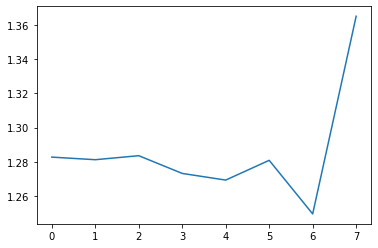

In [102]:
plt.plot(log_loss_array_NB)

In [103]:
best_alpha_NB=alpha[n.argmin(log_loss_array_NB)]
clf=MultinomialNB(alpha=best_alpha_NB)
clf.fit(Train_X_OneHot,Train_y)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(Train_X_OneHot,Train_y)

predict_Train=cali_clf.predict_proba(Train_X_OneHot)
predict_CV=cali_clf.predict_proba(CV_X_OneHot)
predict_Test=cali_clf.predict_proba(Test_X_OneHot)

print("Train log loss:",log_loss(Train_y,predict_Train,labels=clf.classes_,eps=1e-15))
print("CV log loss:",log_loss(CV_y,predict_CV,labels=clf.classes_,eps=1e-15))
print("Test log loss:",log_loss(Test_y,predict_Test,labels=clf.classes_,eps=1e-15))

log_loss_and_confusion_matrix(Train_X_OneHot,Train_y,Test_X_OneHot,Test_y,clf)


Train log loss: 0.9222466433418166
CV log loss: 1.249474802290028
Test log loss: 1.2600761872834172
Log Loss: 1.2600761872834172
Confusion Matrix
 [[ 78   0   1  14   5   4  12   0   0]
 [  7  29   0   0   1   0  54   0   0]
 [  1   0   4   5   1   0   7   0   0]
 [ 38   0   0  83   8   2   6   0   0]
 [ 10   1   0   6  13   4  14   0   0]
 [ 10   5   0   0   4  32   4   0   0]
 [  1  15   5   2   4   0 164   0   0]
 [  1   0   0   0   0   0   3   0   0]
 [  0   0   0   0   0   0   0   0   7]]
665
410
0.38345864661654133


In [104]:
#code from stackoverflow for finding feature importance. needs review didnt work last time. 1 march 2021.
#neg_class_prob_sorted = NB_optimal.feature_log_prob_[0, :].argsort()
#pos_class_prob_sorted = NB_optimal.feature_log_prob_[1, :].argsort()

#print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
#print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

<h3>4.2 KNN</h3>

KNN has the issue of curse of dimensionality. So one hot coding doesnt work here. We need response coding but we dont know how to handle it with text data. One way of handling is converting to word2vec but we will explore it later. so do remove knn later.

In [105]:
alpha=[1,2,7,11,19,25,50,73,100]
log_loss_KNN=[]

for i in alpha:
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(Train_X_OneHot,Train_y)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(Train_X_OneHot,Train_y)
    
    CV_predict=cali_clf.predict_proba(CV_X_OneHot)
    log_loss_KNN.append(log_loss(CV_y,CV_predict,labels=clf.classes_,eps=1e-15))
    print("Alpha:",i," Log Loss:",log_loss(CV_y,CV_predict,labels=clf.classes_,eps=1e-15))

Alpha: 1  Log Loss: 1.3024913887992222
Alpha: 2  Log Loss: 1.2198941819712819
Alpha: 7  Log Loss: 1.2439448739758385
Alpha: 11  Log Loss: 1.2982673509692904
Alpha: 19  Log Loss: 1.3341448292330564
Alpha: 25  Log Loss: 1.3646041559890376
Alpha: 50  Log Loss: 1.3976890307593184
Alpha: 73  Log Loss: 1.284720906741302
Alpha: 100  Log Loss: 1.2760325936021117


<h3>4.3 Logistic Regression</h3>

LR works well with high dimensional data since with many dimensions it is easier to find a hyperplane that will separate our various classes.
We will do LR with class balancing and without class balancing.
<h4>4.3.1 With Class Balancing </h4>

In [106]:
alpha=[10**x for x in range(-6,2)]
log_loss_array=[]

for i in alpha:
    clf=SGDClassifier(loss='log',penalty='l2',alpha=i,class_weight='balanced',random_state=50)
    clf.fit(Train_X_OneHot,Train_y)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(Train_X_OneHot,Train_y)
    
    pred_cv=cali_clf.predict_proba(CV_X_OneHot)
    log_loss_array.append(log_loss(CV_y,pred_cv,labels=clf.classes_,eps=1e-15))
    print("Alpha:",i," Log Loss:",log_loss(CV_y,pred_cv,labels=clf.classes_,eps=1e-15))
    

Alpha: 1e-06  Log Loss: 1.3192812031617942
Alpha: 1e-05  Log Loss: 1.2740717488365796
Alpha: 0.0001  Log Loss: 1.0571706101838638
Alpha: 0.001  Log Loss: 1.0081638854525066
Alpha: 0.01  Log Loss: 1.0849788528178674
Alpha: 0.1  Log Loss: 1.395576766608725
Alpha: 1  Log Loss: 1.6482373717745553
Alpha: 10  Log Loss: 1.6801587416902686


In [107]:
best_alpha=n.argmin(log_loss_array)
clf=SGDClassifier(class_weight='balanced',penalty='l2',alpha=alpha[best_alpha],loss='log',random_state=50)
clf.fit(Train_X_OneHot,Train_y)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(Train_X_OneHot,Train_y)

predict_train=cali_clf.predict_proba(Train_X_OneHot)
print("Train-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Train_y,predict_train,labels=clf.classes_,eps=1e-15))

predict_cv=cali_clf.predict_proba(CV_X_OneHot)
print("CV-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))

predict_test=cali_clf.predict_proba(Test_X_OneHot)
print("Test-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Test_y,predict_test,labels=clf.classes_,eps=1e-15))

Train-> Alpha: 0.001  Log Loss: 0.5349543881951662
CV-> Alpha: 0.001  Log Loss: 1.0081638854525066
Test-> Alpha: 0.001  Log Loss: 1.019061884015911


In [108]:
log_loss_and_confusion_matrix(Train_X_OneHot,Train_y,Test_X_OneHot,Test_y,clf)

Log Loss: 1.019061884015911
Confusion Matrix
 [[ 77   0   1  21  10   3   2   0   0]
 [  7  37   0   2   2   0  43   0   0]
 [  1   0   7   4   0   0   6   0   0]
 [ 20   0   0 105   6   1   5   0   0]
 [  9   1   0   6  15   4  13   0   0]
 [ 10   4   0   2   2  35   2   0   0]
 [  0  19   5   6   3   2 156   0   0]
 [  0   0   0   0   0   0   3   1   0]
 [  0   0   0   0   0   0   0   1   6]]
665
439
0.3398496240601504


<h4>4.3.2 Without Class Balancing </h4>

In [ ]:
alpha=[10**x for x in range(-6,2)]
log_loss_array=[]

for i in alpha:
    clf=SGDClassifier(loss='log',penalty='l2',alpha=i,random_state=50)
    clf.fit(Train_X_OneHot,Train_y)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(Train_X_OneHot,Train_y)
    
    pred_cv=cali_clf.predict_proba(CV_X_OneHot)
    log_loss_array.append(log_loss(CV_y,pred_cv,labels=clf.classes_,eps=1e-15))
    print("Alpha:",i," Log Loss:",log_loss(CV_y,pred_cv,labels=clf.classes_,eps=1e-15))
    

Alpha: 1e-06  Log Loss: 1.282035490823733
Alpha: 1e-05  Log Loss: 1.2387285875482774
Alpha: 0.0001  Log Loss: 1.0701002391863401


In [ ]:
best_alpha=n.argmin(log_loss_array)
clf=SGDClassifier(penalty='l2',alpha=alpha[best_alpha],loss='log',random_state=50)
clf.fit(Train_X_OneHot,Train_y)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(Train_X_OneHot,Train_y)

predict_train=cali_clf.predict_proba(Train_X_OneHot)
print("Train-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Train_y,predict_train,labels=clf.classes_,eps=1e-15))

predict_cv=cali_clf.predict_proba(CV_X_OneHot)
print("CV-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))

predict_test=cali_clf.predict_proba(Test_X_OneHot)
print("Test-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Test_y,predict_test,labels=clf.classes_,eps=1e-15))

In [ ]:
log_loss_and_confusion_matrix(Train_X_OneHot,Train_y,Test_X_OneHot,Test_y,clf)

Note: Advantage with class balancing is that less valued classes are better represented. (read more about it.)

<h3>4.4 SVM</h3>

<p>We will be using linear SVM instead of RBF SVM for two reason. First, we dont know which kernal to use. Second, for high dimensional data linear SVM works really well. SVM uses 'hinge' loss instead of 'log loss'. Also linear SVM also has feature importance. In RBF SVM we cannot find feature importance. </p>

In [ ]:
alpha=[10**x for x in range(-6,2)]
log_loss_SVM=[]

for i in alpha:
    clf=SGDClassifier(class_weight='balanced',alpha=i,loss='hinge',penalty='l2',random_state=50)
    clf.fit(Train_X_OneHot,Train_y)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(Train_X_OneHot,Train_y)
    
    predict_cv=cali_clf.predict_proba(CV_X_OneHot)
    log_loss_SVM.append(log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))
    print("Alpha:",i," Log Loss:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))

In [ ]:
best_alpha=n.argmin(alpha)

clf=SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha],loss='hinge',penalty='l2',random_state=50)
clf.fit(Train_X_OneHot,Train_y)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(Train_X_OneHot,Train_y)

predict_train=cali_clf.predict_proba(Train_X_OneHot)
print("Train-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Train_y,predict_train,labels=clf.classes_,eps=1e-15))

predict_cv=cali_clf.predict_proba(CV_X_OneHot)
print("CV-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))

predict_test=cali_clf.predict_proba(Test_X_OneHot)
print("Test->Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Test_y,predict_test,labels=clf.classes_,eps=1e-15))

In [ ]:
log_loss_and_confusion_matrix(Train_X_OneHot,Train_y,Test_X_OneHot,Test_y,clf)

<h3> 4.5 Random Forest </h3>
<p>Random forest is an ensemble model, bootstrapped aggregation, with Decision trees as base model. DT works well with less dimensional data. But we will try one hot encoding on RF.
Read about random forest in yellow notebook. It has two variables, n_estimators(number of decision trees in forest), and max_depth( the allowed depth of trees). So we will have to run nested for loops for both the variables.</p>

In [ ]:
alpha=[50,100,200,500,1000,2000]
max_depth=[5,10]
rf_log_loss_array=[]

for i in alpha:
    for j in max_depth:
        clf=RandomForestClassifier(n_estimators=i,criterion='gini',max_depth=j,random_state=42,n_jobs=-1)
        clf.fit(Train_X_OneHot,Train_y)
        
        cali_clf=CalibratedClassifierCV(clf,method="sigmoid")
        cali_clf.fit(Train_X_OneHot,Train_y)
        
        predict_cv=cali_clf.predict_proba(CV_X_OneHot)
        rf_log_loss_array.append(log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))
        print("Alpha:",i," Max_Depth:",j,"Log Loss:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))

In [ ]:
best_alpha=n.argmin(rf_log_loss_array)
clf=RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)],criterion='gini',max_depth=max_depth[int(best_alpha%2)],random_state=50,n_jobs=-1)
clf.fit(Train_X_OneHot,Train_y)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(Train_X_OneHot,Train_y)

predict_train=cali_clf.predict_proba(Train_X_OneHot)
predict_cv=cali_clf.predict_proba(CV_X_OneHot)
predict_test=cali_clf.predict_proba(Test_X_OneHot)

print("For alpha:",alpha[int(best_alpha/2)]," Max_depth:",max_depth[int(best_alpha%2)]," Log Loss Train:",log_loss(Train_y,predict_train,labels=clf.classes_,eps=1e-15))
print("For alpha:",alpha[int(best_alpha/2)]," Max_depth:",max_depth[int(best_alpha%2)]," Log Loss CV:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))
print("For alpha:",alpha[int(best_alpha/2)]," Max_depth:",max_depth[int(best_alpha%2)]," Log Loss Test:",log_loss(Test_y,predict_test,labels=clf.classes_,eps=1e-15))
